In [1]:
from rdkit import (Chem, DataStructs, Geometry)
from rdkit.Chem import (Draw, AllChem, PandasTools, rdFingerprintGenerator)
from kinfraglib import utils
import matplotlib.pyplot as plt
import seaborn as sns
import utils_eval
import math
from copy import deepcopy
import itertools
from rdkit.Chem.Draw import rdMolDraw2D

from collections import defaultdict
from PIL import Image as pilImage
from io import BytesIO


In [2]:
# read data
data = utils_eval.read_mols('../final_results/3amb/results.sdf')
data['binding_affinity'] = data.apply(lambda x: (x['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM]'] + x['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM]'])/2, axis=1)
data = data[data['binding_affinity'] <= 1000].copy().reset_index(drop=True)
data['inchi'] = data.apply(lambda x: Chem.MolToInchi(utils.standardize_mol(x.ROMol)), axis=1)

In [3]:
# convert fragment_ids
for sp in ['AP', 'SE', 'FP', 'GA']:
    data[sp] = data.apply(lambda x: x.fragment_ids.get(sp), axis=1)
    data[sp + '_smiles'] = data.apply(lambda x: (x.smiles_fragments_dummy.get(sp) if '*' in x.smiles_fragments.get(sp) else x.smiles_fragments.get(sp)) if x.smiles_fragments_dummy.get(sp) else None, axis=1)
data

,ROMol,BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM],BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM],BIOSOLVEIT.LOGP,BIOSOLVEIT.MOLECULAR_WEIGHT,BIOSOLVEIT.TPSA,fragment_ids,smiles_ligand,smiles_fragments_dummy,smiles_fragments,...,binding_affinity,inchi,AP,AP_smiles,SE,SE_smiles,FP,FP_smiles,GA,GA_smiles
0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.145501,14.456369,4.44350,352.436,64.10,"{'AP': 345, 'SE': 114}",COc1ccc(OC)c(-c2cc(Nc3cc(C4CCC4)[nH]n3)n(C)c2)c1,"{'AP': 'Nc1cc(C2CCC2)[nH]n1', 'SE': '[30*]c1cc...","{'AP': '[22*]Nc1cc(C2CCC2)[nH]n1', 'SE': 'COc1...",...,7.300935,InChI=1S/C20H24N4O2/c1-24-12-14(16-10-15(25-2)...,345,Nc1cc(C2CCC2)[nH]n1,114,COc1ccc(OC)c(-c2ccn(C)c2)c1,NaN,None,NaN,None
1,"<img data-content=""rdkit/molecule"" src=""data:i...",0.185049,18.385735,2.89520,408.446,86.42,"{'AP': 345, 'SE': 149}",O=C(NC1CC[NH2+]CC1)c1cc(Nc2cc(C3CCC3)[nH]n2)cc...,"{'AP': 'Nc1cc(C2CCC2)[nH]n1', 'SE': '[34*]c1cc...","{'AP': '[22*]Nc1cc(C2CCC2)[nH]n1', 'SE': 'O=C(...",...,9.285392,"InChI=1S/C20H24F3N5O/c21-20(22,23)14-8-13(19(2...",345,Nc1cc(C2CCC2)[nH]n1,149,O=C(NC1CC[NH2+]CC1)c1cccc(C(F)(F)F)c1,NaN,None,NaN,None
2,"<img data-content=""rdkit/molecule"" src=""data:i...",0.219514,21.810011,1.57070,369.486,83.62,"{'AP': 79, 'SE': 113}",O=C(NCc1ccc(OCC2CC[NH2+]CC2)cc1)c1n[nH]c2c1CCCC2,"{'AP': 'CNC(=O)c1n[nH]c2c1CCCC2', 'SE': '[12*]...",{'AP': '[22*][C@@H]1CCc2[nH]nc(C(=O)NC[27*])c2...,...,11.014762,InChI=1S/C21H28N4O2/c26-21(20-18-3-1-2-4-19(18...,79,CNC(=O)c1n[nH]c2c1CCCC2,113,c1ccc(OCC2CC[NH2+]CC2)cc1,NaN,None,NaN,None
3,"<img data-content=""rdkit/molecule"" src=""data:i...",0.237646,23.611544,4.05340,338.409,64.10,"{'AP': 5, 'SE': 114}",COc1ccc(OC)c(-c2cc(Nc3cc(C4CC4)[nH]n3)n(C)c2)c1,"{'AP': 'Nc1cc(C2CC2)[nH]n1', 'SE': '[30*]c1cc(...","{'AP': '[17*]Nc1cc(C2CC2)[nH]n1', 'SE': 'COc1c...",...,11.924595,InChI=1S/C19H22N4O2/c1-23-11-13(15-9-14(24-2)6...,5,Nc1cc(C2CC2)[nH]n1,114,COc1ccc(OC)c(-c2ccn(C)c2)c1,NaN,None,NaN,None
4,"<img data-content=""rdkit/molecule"" src=""data:i...",0.243479,24.191076,2.45132,314.387,90.04,"{'AP': 345, 'SE': 306}",Cc1ccc(C(=O)NCCO)cc1Nc1cc(C2CCC2)[nH]n1,"{'AP': 'Nc1cc(C2CCC2)[nH]n1', 'SE': '[16*]c1cc...","{'AP': '[22*]Nc1cc(C2CCC2)[nH]n1', 'SE': 'Cc1c...",...,12.217277,InChI=1S/C17H22N4O2/c1-11-5-6-13(17(23)18-7-8-...,345,Nc1cc(C2CCC2)[nH]n1,306,Cc1ccc(C(=O)NCCO)cc1,NaN,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9189,"<img data-content=""rdkit/molecule"" src=""data:i...",12.195554,1211.700388,6.77280,612.778,113.76,"{'AP': 185, 'SE': 47, 'FP': 275, 'GA': 53}",CNC(=O)c1cccc2cc(CCc3cc(Nc4cccc(C5CCN(NC(C)c6c...,"{'AP': 'CCc1cc(N)n[nH]1', 'SE': '[21*]c1cccc(C...","{'AP': '[16*]CCc1cc(N[22*])n[nH]1', 'SE': 'c1c...",...,611.947971,InChI=1S/C37H40N8O/c1-24(33-13-14-34-35(41-33)...,185,CCc1cc(N)n[nH]1,47,c1ccc(C2CCNCC2)cc1,275.0,C[C@H](N)c1ccc2[nH]ccc2n1,53.0,CNC(=O)c1cccc2ccccc12
9190,"<img data-content=""rdkit/molecule"" src=""data:i...",12.380109,1230.037042,1.20250,596.776,106.60,"{'AP': 79, 'SE': 19, 'FP': 345, 'GA': 92}",COc1ccc(-c2ncn(CC3CC3)c2C2CCc3n[nH]c(C(=O)NCc4...,"{'AP': 'CNC(=O)c1n[nH]c2c1CCCC2', 'SE': '[1*]c...",{'AP': '[22*][C@@H]1CCc2[nH]nc(C(=O)NC[27*])c2...,...,621.208575,InChI=1S/C34H42N8O2/c1-40-13-15-41(16-14-40)20...,79,CNC(=O)c1n[nH]c2c1CCCC2,19,C[NH+]1CCN(Cc2ccccc2)CC1,345.0,c1cn(CC2CC2)cn1,92.0,COc1ccccn1
9191,"<img data-content=""rdkit/molecule"" src=""data:i...",12.472786,1239.245025,4.40578,587.685,139.33,"{'AP': 79, 'SE': 40, 'FP': 345, 'GA': 93}",COc1ccc(-c2ncn(CC3CC3)c2C2CCc3n[nH]c(C(=O)NCc4...,"{'AP': 'CNC(=O)c1n[nH]c2c1CCCC2', 'SE': '[22*]...",{'AP': '[22*][C@@H]1CCc2[nH]nc(C(=O)NC[27*])c2...,...,625.858905,InChI=1S/C33H33N9O2/c1-44-26-8-10-29(35-16-26)...,79,CNC(=O)c1n[nH]c2c1CCCC2,40,N#Cc1cccc(Cn2cccn2)c1,345.0,c1cn(CC2CC2)cn1,93.0,COc1cccnc1
9192,"<img data-content=""rdkit/molecule"" src=""data:i...",14.859827,1476.411653,2.98260,603.191,111.96,"{'AP': 79, 'SE': 135, 'FP': 345, 'GA': 17

In [39]:
print(f"Duplicates: {sum(data.inchi.duplicated())}")

Duplicates: 412


# Murcko Similarity

In [5]:
# add murcko smiles 
PandasTools.AddMurckoToFrame(data)

In [6]:
scaffolds = data.groupby('Murcko_SMILES').size()
scaffolds = scaffolds.sort_values(ascending=False)
# apply scaffold ids
data['scaffold_id'] = data.apply(lambda x: scaffolds.index.get_loc(x.Murcko_SMILES), axis=1)

In [7]:
print(f"# scaffolds: {scaffolds.size}")

# scaffolds: 4742


In [8]:
data['is_singleton'] = data.apply(lambda x: scaffolds[x.Murcko_SMILES] == 1, axis=1)

In [9]:
singletons = data[data['is_singleton']]

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, -200.0, '−200'),
  Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200')])

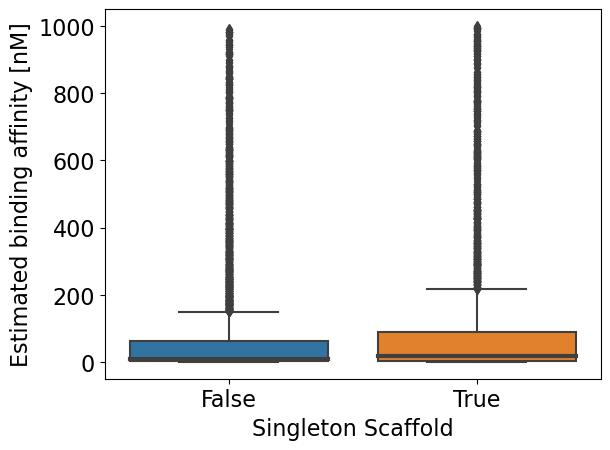

In [10]:
sns.boxplot(
    x = 'is_singleton',
    y='binding_affinity',
    data=data,
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Singleton Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [11]:
print(f"# singletons: {sum(scaffolds == 1)}")

# singletons: 3702


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, -200.0, '−200'),
  Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200')])

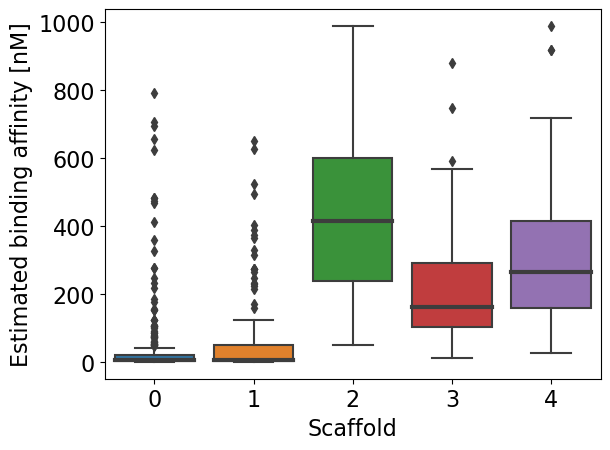

In [12]:
# plot binding affinity of top 5
sns.boxplot(
    x = 'scaffold_id',
    y='binding_affinity',
    data=data[data['scaffold_id'] < 5],
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, -200.0, '−200'),
  Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200')])

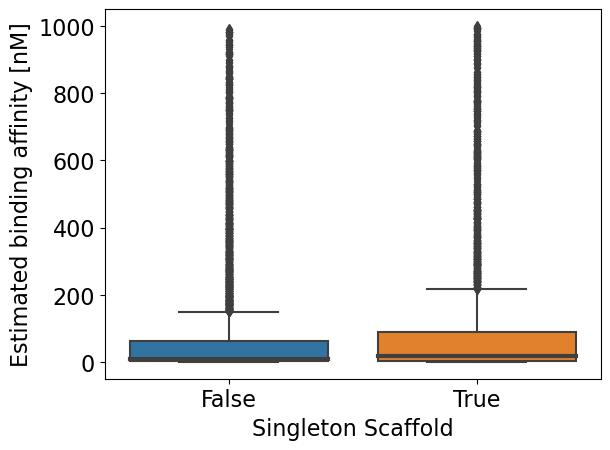

In [13]:
# plot binding affinity of top 5
sns.boxplot(
    x = 'is_singleton',
    y='binding_affinity',
    data=data,
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Singleton Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350')])

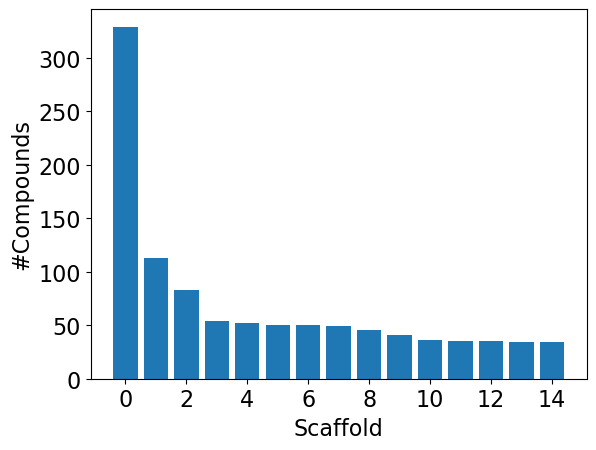

In [14]:
# plot top 15 scaffolds TODO add percetage to top of the bars
plt.bar(range(15), scaffolds[:15])
plt.ylabel('#Compounds', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [15]:
print(f"Scaffold 0: {scaffolds[0]} compounds => {scaffolds[0]/data.index.size * 100}%")

Scaffold 0: 329 compounds => 3.5784207091581464%


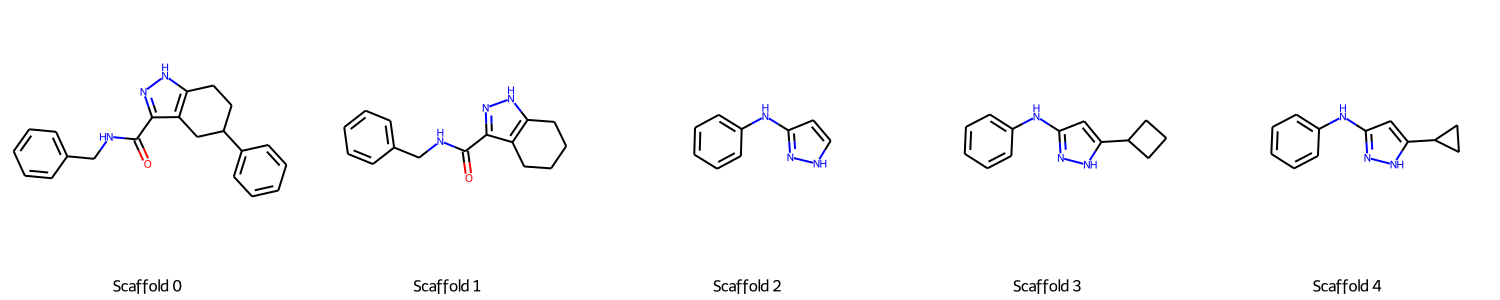

In [16]:
# print most common scaffolds
mols = [AllChem.MolFromSmiles(idx) for idx in scaffolds.index[:5]]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols, 
    legends=[
        f"Scaffold {i}" for i in range(5)
    ],  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)
img

In [17]:
# from adapted from https://greglandrum.github.io/rdkit-blog/posts/2021-08-07-rgd-and-highlighting.html
def highlight_scaffold(mol,patt, color, width=350,height=200,
                      fillRings=True,legend=""):
    # copy the molecule and core
    mol = Chem.Mol(mol)

    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps

  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    AllChem.Compute2DCoords(mol)
    hit_ats = list(mol.GetSubstructMatch(patt))

    rings = []   
    rinfo = mol.GetRingInfo()
    for at_idx in list(mol.GetSubstructMatch(patt)):
        highlightatoms[at_idx].append(color)
        atomrads[at_idx] = 0.4
    if fillRings:
        for aring in rinfo.AtomRings():
            tring = []
            allFound = True
            for aid in aring:
                if aid in hit_ats:
                    tring.append(aid)
            if allFound:
                rings.append((tring,color))
    for qbnd in patt.GetBonds():
        batom = hit_ats[qbnd.GetBeginAtomIdx()]
        eatom = hit_ats[qbnd.GetEndAtomIdx()]
        bndIdx = mol.GetBondBetweenAtoms(batom,eatom).GetIdx()
        highlightbonds[bndIdx].append(color)
        widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(mol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = mol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(mol,legend,dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()
    return png

def draw_multiple(ms,pattern,legends=None,nPerRow=5,subImageSize=(250,200)):
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    # colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    #colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(0,158,115),(86,180,233),(204,121,167),(0,114,178),(230,159,0),(213,94,0),(240,228,66)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)

    nRows = len(ms)//nPerRow
    if len(ms)%nPerRow:
        nRows+=1
    nCols = nPerRow
    imgSize = (subImageSize[0]*nCols,subImageSize[1]*nRows)
    res = pilImage.new('RGB',imgSize)
    
    for i,m in enumerate(ms):
        col = i%nPerRow
        row = i//nPerRow
        if legends:
            legend = legends[i]
        else:
            legend = ''
        png = highlight_scaffold(m,pattern[i],legend=legend,
                               width=subImageSize[0],height=subImageSize[1], color = colors[i//nPerRow])
        bio = BytesIO(png)
        img = pilImage.open(bio)
        res.paste(img,box=(col*subImageSize[0],row*subImageSize[1]))
    bio = BytesIO()
    res.save(bio,format='PNG')
    return bio.getvalue()

In [35]:
mols = []
scaffolds_pattern =[]
legend = []
paint_bonds = []
paint_atoms = []
for i in range(5):
    scaffold_compounds = data[data['scaffold_id'] == i].copy()
    scaffold_compounds = scaffold_compounds.drop_duplicates(subset=['inchi'])
    mols += [mol for mol in scaffold_compounds['ROMol'][:5]]
    scaffolds_pattern += [AllChem.MolFromSmarts(smiles) for smiles in scaffold_compounds['Murcko_SMILES'][:5]]
    legend += [f"Scaffold {i} compound" for _ in range(5)]

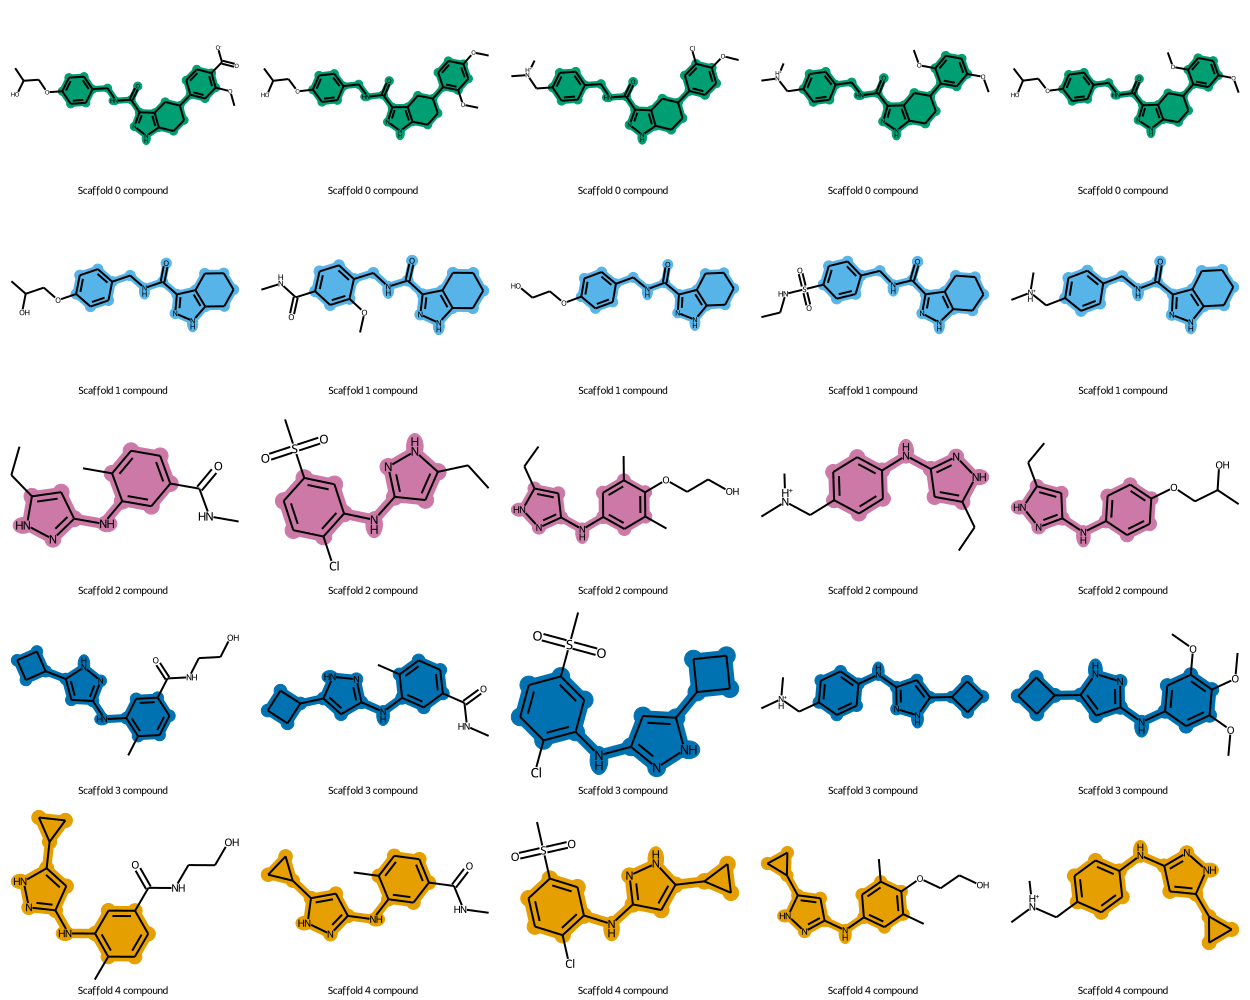

In [36]:
from IPython import display
display.Image(draw_multiple(mols, scaffolds_pattern, legends=legend))

Text(0.5, 0, '# Unique AP fragments')

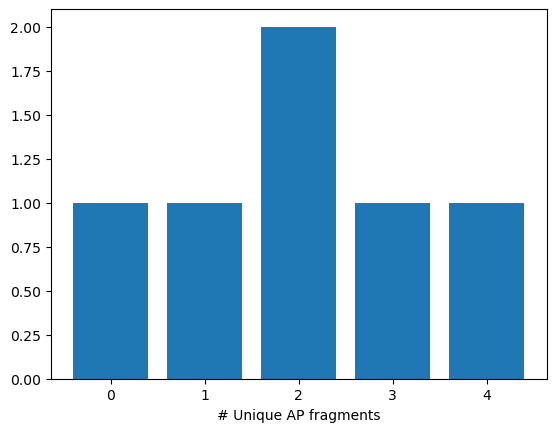

In [20]:
# unique AP fragments per scaffold
plt.bar(range(5), [data[data['scaffold_id'] == i]['AP'].unique().size for i in range(5)])
plt.xlabel("# Unique AP fragments")

Legend: Fragment id | Scaffold


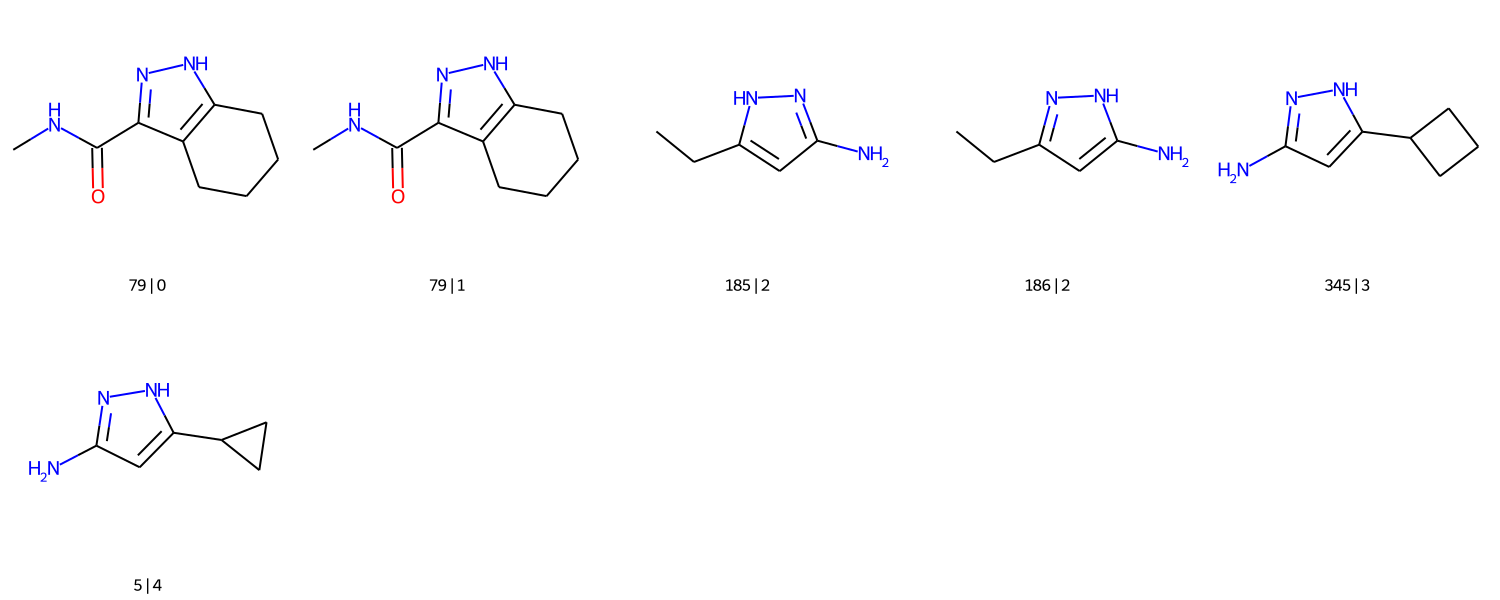

In [21]:
mols = []
legend = []
for i in range(5):
    scaffold_compounds = data[data['scaffold_id'] == i]
    mols += [AllChem.MolFromSmiles(mol) for mol in scaffold_compounds['AP_smiles'].unique()]
    legend += [f"{id} | {i}" for id in scaffold_compounds['AP'].unique()]
# print most common scaffolds
for mol in mols:
    AllChem.Compute2DCoords(mol)
print(f"Legend: Fragment id | Scaffold")
Draw.MolsToGridImage(
    mols, 
    legends=legend,  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)

In [22]:
# Shannon entropy
P = data.index.size
se = - sum((scaffold / P) * math.log2(scaffold / P) for scaffold in scaffolds)
sse = se / math.log2(scaffolds.size)
print(f"SE: {se}\nSSE: {sse}")

SE: 11.126296537530125
SSE: 0.9111490839110924


# Tanimoto similarity

In [23]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.append([1 - x for x in similarities])
    return dissimilarity_matrix

In [24]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
data['rdkit_fingerprint'] = [rdkit_gen.GetFingerprint(Chem.MolFromInchi(ligand_inchi)) for ligand_inchi in data.inchi]

In [25]:
mean_sims = []
nearest_neighbor = []
all_similarities = []
for idx in data.index:
    similarities = DataStructs.BulkTanimotoSimilarity(data.rdkit_fingerprint[idx], data.rdkit_fingerprint)
    all_similarities.append(similarities.copy())
    similarities.remove(1) # self simimlarity
    mean_sims.append((sum(similarities)) / (len(similarities)))
    nearest_neighbor.append(max(similarities))
data['mean_tanimoto_sims'] = mean_sims
data['nearest_neighbor_sim'] = nearest_neighbor

In [26]:
data[data['inchi'].duplicated(keep=False)].sort_values("inchi")

,ROMol,BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM],BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM],BIOSOLVEIT.LOGP,BIOSOLVEIT.MOLECULAR_WEIGHT,BIOSOLVEIT.TPSA,fragment_ids,smiles_ligand,smiles_fragments_dummy,smiles_fragments,...,FP,FP_smiles,GA,GA_smiles,Murcko_SMILES,scaffold_id,is_singleton,rdkit_fingerprint,mean_tanimoto_sims,nearest_neighbor_sim
725,"<img data-content=""rdkit/molecule"" src=""data:i...",11.122449,1105.081035,2.46800,259.234,58.53,"{'AP': 185, 'SE': 188}",CCc1cc(Nc2cn(C)nc2C(F)(F)F)n[nH]1,"{'AP': 'CCc1cc(N)n[nH]1', 'SE': '[31*]c1cn(C)n...","{'AP': '[16*]CCc1cc(N[22*])n[nH]1', 'SE': 'Cn1...",...,NaN,None,NaN,None,c1cc(Nc2cn[nH]c2)n[nH]1,326,False,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.205301,1.0
728,"<img data-content=""rdkit/molecule"" src=""data:i...",11.140512,1106.875710,2.46800,259.234,58.53,"{'AP': 186, 'SE': 188}",CCc1cc(Nc2cn(C)nc2C(F)(F)F)n[nH]1,"{'AP': 'CCc1cc(N)[nH]n1', 'SE': '[31*]c1cn(C)n...","{'AP': '[8*]Nc1cc(CC[19*])n[nH]1', 'SE': 'Cn1c...",...,NaN,None,NaN,None,c1cc(Nc2cn[nH]c2)n[nH]1,326,False,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.205301,1.0
693,"<img data-content=""rdkit/molecule"" src=""data:i...",10.264607,1019.849349,2.78904,222.314,53.60,"{'AP': 186, 'SE': 68}",CCc1cc(Nc2sc(C)nc2C)n[nH]1,"{'AP': 'CCc1cc(N)[nH]n1', 'SE': '[39*]c1sc(C)n...","{'AP': '[8*]Nc1cc(CC[19*])n[nH]1', 'SE': 'Cc1c...",...,NaN,None,NaN,None,c1cc(Nc2cncs2)n[nH]1,200,False,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.211656,1.0
737,"<img data-content=""rdkit/molecule"" src=""data:i...",11.351351,1127.823837,2.78904,222.314,53.60,"{'AP': 185, 'SE': 68}",CCc1cc(Nc2sc(C)nc2C)n[nH]1,"{'AP': 'CCc1cc(N)n[nH]1', 'SE': '[39*]c1sc(C)n...","{'AP': '[16*]CCc1cc(N[22*])n[nH]1', 'SE': 'Cc1...",...,NaN,None,NaN,None,c1cc(Nc2cncs2)n[nH]1,200,False,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.211656,1.0
920,"<img data-content=""rdkit/molecule"" src=""data:i...",18.288357,1817.056445,4.02250,256.135,40.71,"{'AP': 185, 'SE': 169}",CCc1cc(Nc2ccc(Cl)cc2Cl)n[nH]1,"{'AP': 'CCc1cc(N)n[nH]1', 'SE': '[12*]c1ccc(Cl...","{'AP': '[16*]CCc1cc(N[22*])n[nH]1', 'SE': 'Clc...",...,NaN,None,NaN,None,c1ccc(Nc2cc[nH]n2)cc1,2,False,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.219189,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,"<img data-content=""rdkit/molecule"" src=""data:i...",0.024041,2.388655,4.66850,600.179,103.85,"{'AP': 79, 'SE': 61, 'FP': 5}",CC(O)COc1ccc(CNC(=O)c2n[nH]c3c2CC(c2ccc(C4(c5c...,{'AP': '[22*][C@@H]1CCc2[nH]nc(C(=O)NC[27*])c2...,"{'AP': 'CNC(=O)c1n[nH]c2c1CCCC2', 'SE': '[18*]...",...,5.0,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,None,O=C(NCc1ccccc1)c1n[nH]c2c1CC(c1ccc(C3(c4ccccc4...,180,False,"[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.535938,1.0
717,"<img data-content=""rdkit/molecule"" src=""data:i...",10.924997,1085.463003,1.15490,183.253,60.94,"{'AP': 186, 'SE': 153}",CCc1cc(NC(CC)CO)n[nH]1,"{'AP': 'CCc1cc(N)[nH]n1', 'SE': '[41*][C@@H](C...","{'AP': '[8*]Nc1cc(CC[19*])n[nH]1', 'SE': 'CCCCO'}",...,NaN,None,NaN,None,c1cn[nH]c1,286,False,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.195648,1.0
686,"<img data-content=""rdkit/molecule"" src=""data:i...",10.123617,1005.841160,1.15490,183.253,60.94,"{'AP': 185, 'SE': 153}",CCc1cc(NC(CC)CO)n[nH]1,"{'AP': 'CCc1cc(N)n[nH]1', 'SE': '[41*][C@@H](C...","{'AP': '[16*]CCc1cc(N[22*])n[nH]1', 'SE': 'CCC...",...,NaN,None,NaN,None,c1cn[nH]c1,286,False,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.195648,1.0
543,"<img data-content=""rdkit/molecule"" src=""data:i...",7.125615,707.971978,1.46770,231.317,74.85,"{'AP': 185, 'SE': 304}",CCc1cc(NC(C)CS(C)(=O)=O)n[nH]1,"{'AP': 'CCc1cc(N)n[nH]1', 'SE': '[18*][C@H](C)...","{'AP': '[16*]CCc1cc(N[22*])n[nH]1', 'SE': 'CCC...",...,NaN,None,NaN,None,c1cn[nH]c1,286,False,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.191436,1.0


(array([  12.,   31.,  312.,  510.,  338.,   29.,  352., 2590., 3647.,
        1373.]),
 array([0.1155422 , 0.16089385, 0.2062455 , 0.25159715, 0.29694879,
        0.34230044, 0.38765209, 0.43300374, 0.47835539, 0.52370704,
        0.56905868]),
 <BarContainer object of 10 artists>)

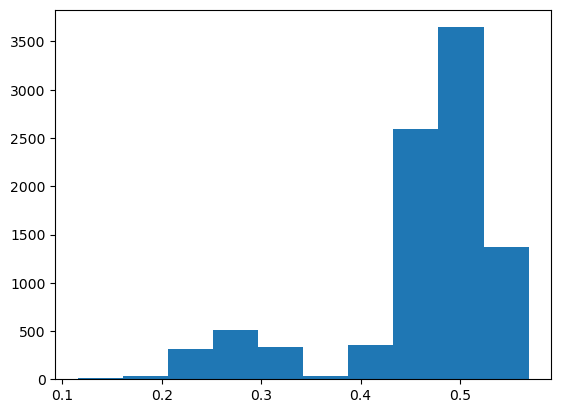

In [27]:
plt.hist(data['mean_tanimoto_sims'])

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500')])

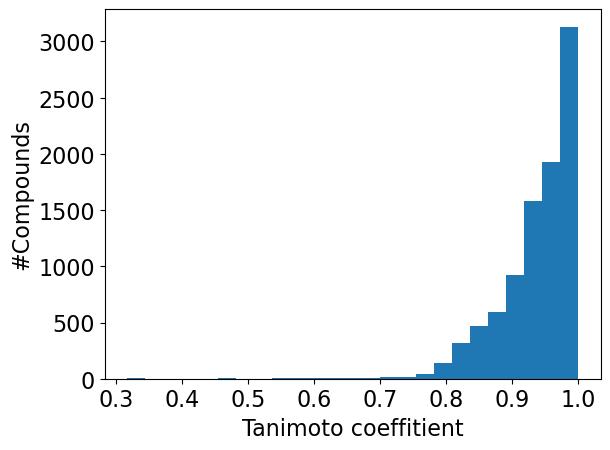

In [28]:
plt.hist(data['nearest_neighbor_sim'], bins=25)
plt.xlabel('Tanimoto coeffitient', fontsize=16)
plt.ylabel('#Compounds', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

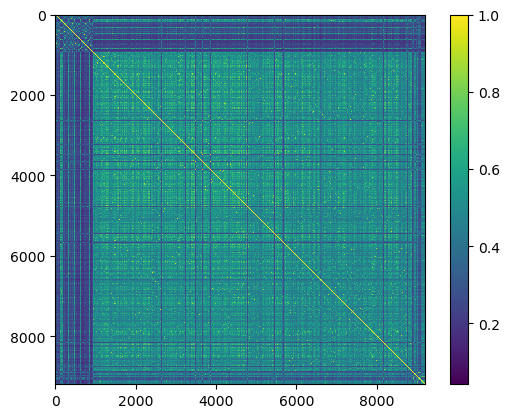

In [29]:
plt.imshow(all_similarities, interpolation='nearest')
plt.colorbar()

/opt/homebrew/Caskroom/mambaforge/base/envs/king_frag_lib_pocket_enum/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


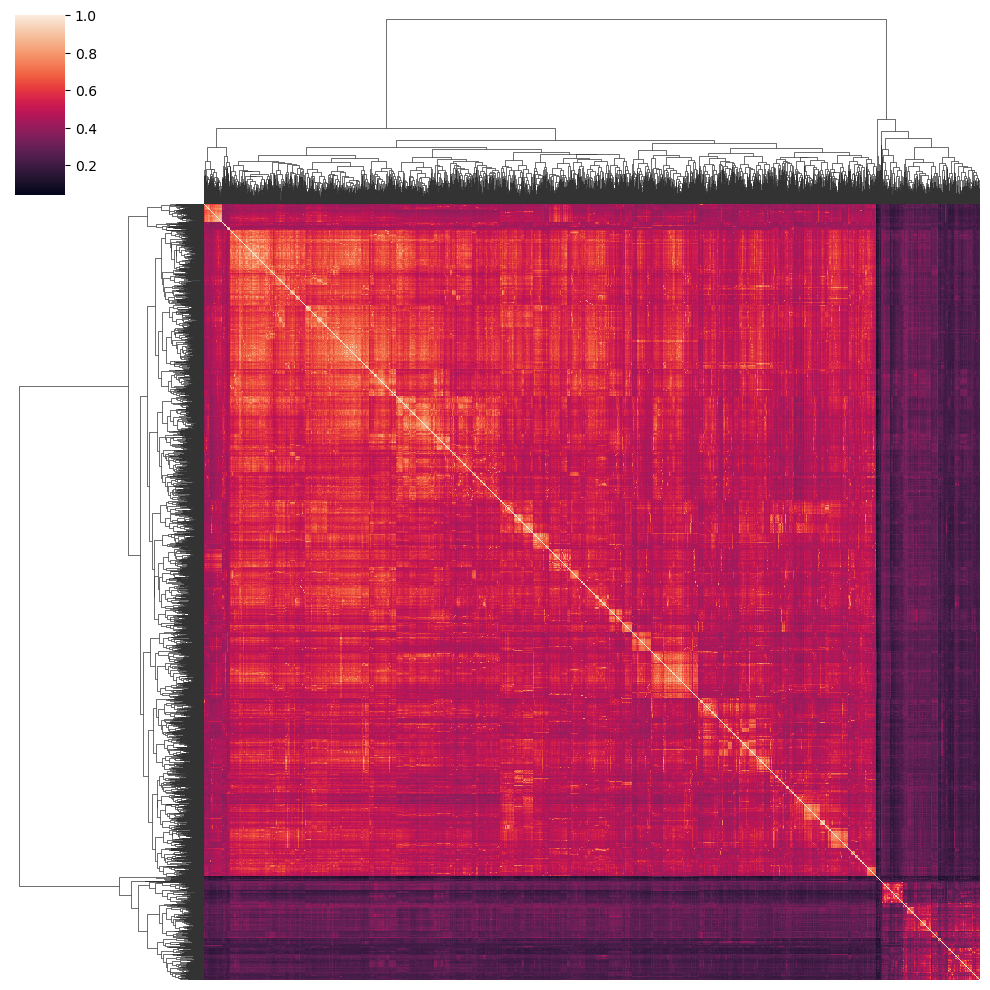

In [37]:
g = sns.clustermap(all_similarities, yticklabels=False,xticklabels=False)

In [31]:
print(f"Tanimoto mean similarity stats\n{data['mean_tanimoto_sims'].describe()}")

Tanimoto mean similarity stats
count    9194.000000
mean        0.460619
std         0.081213
min         0.115542
25%         0.452008
50%         0.483339
75%         0.509568
max         0.569059
Name: mean_tanimoto_sims, dtype: float64


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

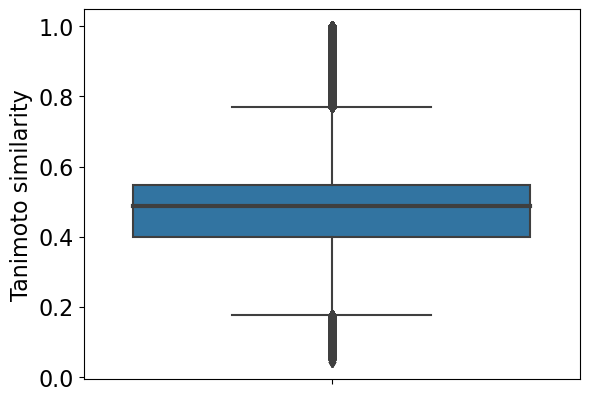

In [32]:
sns.boxplot(
    y=list(itertools.chain(*all_similarities)),
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Tanimoto similarity', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)